In [9]:
from pyspark.sql import SparkSession
import glob
import numpy as np
import pandas as pd
import os
import concurrent.futures
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
#Set Environment accordingly
os.environ['JAVA_HOME'] = "/Library/Java/JavaVirtualMachines/adoptopenjdk-8.jdk/Contents/Home/"
os.environ['SPARK_HOME'] = "/Users/simran/Downloads/spark-3.5.5-bin-hadoop3/"

In [3]:
directory_path = "./data/full_history"
file_pattern = "*.csv"

In [4]:

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("BigDataProject1") \
    .config("spark.driver.bindAddress", "127.0.0.1") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.memory", "15g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.memory.offHeap.enabled", True) \
    .config("spark.memory.offHeap.size", "20g") \
    .config("spark.default.parallelism", "100") \
    .config("spark.sql.shuffle.partitions", "200") \
    .config("spark.executor.extraJavaOptions", "-XX:+UseG1GC") \
    .config("spark.serializer", "org.apache.spark.serializer.JavaSerializer") \
    .getOrCreate()


25/05/03 14:17:30 WARN Utils: Your hostname, Simrans-MacBook-Pro.local resolves to a loopback address: 127.0.0.1; using 192.168.1.222 instead (on interface en0)
25/05/03 14:17:30 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/03 14:17:31 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [5]:
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, DateType

schema = StructType([
    StructField("date", DateType(), True),
    StructField("volume", DoubleType(), True),  
    StructField("open", DoubleType(), True),
    StructField("high", DoubleType(), True),
    StructField("low", DoubleType(), True),
    StructField("close", DoubleType(), True),
    StructField("adj close", DoubleType(), True),
    StructField("StockName", StringType(), True)
])

In [6]:
# Load datasets as DataFrames
history_df = spark.read.format("csv") \
     .option("header", "true") \
     .option("treatEmptyValuesAsNulls", "true") \
     .option("schema",schema) \
     .load(f"{directory_path}/{file_pattern}")


history_df.show(5)

+----------+-------+-----------------+------------------+------------------+------------------+------------------+---------+
|      date| volume|             open|              high|               low|             close|         adj close|StockName|
+----------+-------+-----------------+------------------+------------------+------------------+------------------+---------+
|2023-12-28|5703600|30.14999961853028|30.239999771118164|29.950000762939453| 30.18000030517578| 30.18000030517578|      HPQ|
|2023-12-27|5127900|30.39999961853028|30.520000457763672|30.209999084472656|30.239999771118164|30.239999771118164|      HPQ|
|2023-12-26|4853600|30.13999938964844|30.549999237060547|30.059999465942383| 30.40999984741211| 30.40999984741211|      HPQ|
|2023-12-22|4476400|30.21999931335449|30.479999542236328| 30.06999969482422| 30.18000030517578| 30.18000030517578|      HPQ|
|2023-12-21|6529200|30.07999992370605| 30.21999931335449| 29.90999984741211| 30.13999938964844| 30.13999938964844|      HPQ|


In [7]:
# Remove duplicates
history_df = history_df.dropDuplicates()

# Handle missing values for both open and close simultaneously
history_df = history_df.na.fill({
    "open": np.nan,
    "close": np.nan
})
history_df = history_df.replace(float('nan'), None)

history_df.cache()


DataFrame[date: string, volume: string, open: string, high: string, low: string, close: string, adj close: string, StockName: string]

In [8]:
history_df.describe().show()

25/05/03 14:20:00 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+----------+--------------------+--------+--------------------+--------------------+--------+--------------------+---------+
|summary|      date|              volume|    open|                high|                 low|   close|           adj close|StockName|
+-------+----------+--------------------+--------+--------------------+--------------------+--------+--------------------+---------+
|  count|  29675300|            29675043|29675300|            29675043|            29675043|29675300|            29675043| 29675300|
|   mean|      NULL|  1218955.7366696654|     NaN|1.538009260333542E10|1.469882232555163...|     NaN|-5.88525798081733...|      NaN|
| stddev|      NULL|1.2938394989509307E7|     NaN|2.937609262009877...|2.811944953441444...|     NaN|9.950828002441017E18|      NaN|
|    min|1962-01-02|                   0|       0|                 0.0|                 0.0|     0.0|                -0.0|        A|
|    max|2023-12-28|            99999600|     NaN|              9999.

In [9]:
history_df.count()


29675300

In [4]:
#Convert Data to Pandas DataFrame to plot visualisations

all_files = glob.glob("./data/full_history/*.csv")

history_df_pd = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)



In [11]:
#Data Visualisations

#Time series visualisation given stock name

import matplotlib.pyplot as plt
import ipywidgets as widgets
import matplotlib.dates as mdate
from IPython.display import display


# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=sorted(list(history_df_pd['StockName'].unique())),
    description='StockNames:'
)

# Function to update the plot based on dropdown selection
def update_plot(category):
    plt.clf() # Clear previous plot
    filtered_df = history_df_pd[history_df_pd['StockName'] == category]
    filtered_df.loc[:,'date'] = pd.to_datetime(filtered_df['date'])
    # Plotting closing prices for a single stock
    sorted_filtered_df = filtered_df.sort_values(by='date')
    plt.plot(sorted_filtered_df['date'], sorted_filtered_df['close'])
    plt.title(f'Plot for {category}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    locator = mdate.YearLocator()
    plt.gca().xaxis.set_major_locator(locator)

    plt.gcf().autofmt_xdate()


# Observe the dropdown value and update the plot
out = widgets.interactive_output(update_plot, {'category': dropdown})

# Display the dropdown and the initial plot

display(dropdown, out)

Dropdown(description='StockNames:', options=('A', 'AA', 'AAAU', 'AACG', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', …

Output()

In [12]:
#Data Visualisations

#Moving Averages visualisation given stock name


# Create the dropdown widget
dropdown = widgets.Dropdown(
    options=sorted(list(history_df_pd['StockName'].unique())),
    description='StockNames:'
)

# Function to update the plot based on dropdown selection
def update_plot(category):
    plt.clf() # Clear previous plot
    filtered_df = history_df_pd[history_df_pd['StockName'] == category]
    filtered_df.loc[:,'date'] = pd.to_datetime(filtered_df['date'])
    # Plotting closing prices for a single stock
    sorted_filtered_df = filtered_df.sort_values(by='date')
    ma100 = sorted_filtered_df.close.rolling(100).mean()
    plt.plot(sorted_filtered_df['date'], sorted_filtered_df['close'])
    plt.plot(sorted_filtered_df['date'],ma100, 'r')
    plt.title(f'Plot for {category}')
    plt.xlabel('Time')
    plt.ylabel('Price')
    locator = mdate.YearLocator()
    plt.gca().xaxis.set_major_locator(locator)

    plt.gcf().autofmt_xdate()


# Observe the dropdown value and update the plot
out = widgets.interactive_output(update_plot, {'category': dropdown})

# Display the dropdown and the initial plot

display(dropdown, out)

Dropdown(description='StockNames:', options=('A', 'AA', 'AAAU', 'AACG', 'AADR', 'AAL', 'AAMC', 'AAME', 'AAN', …

Output()

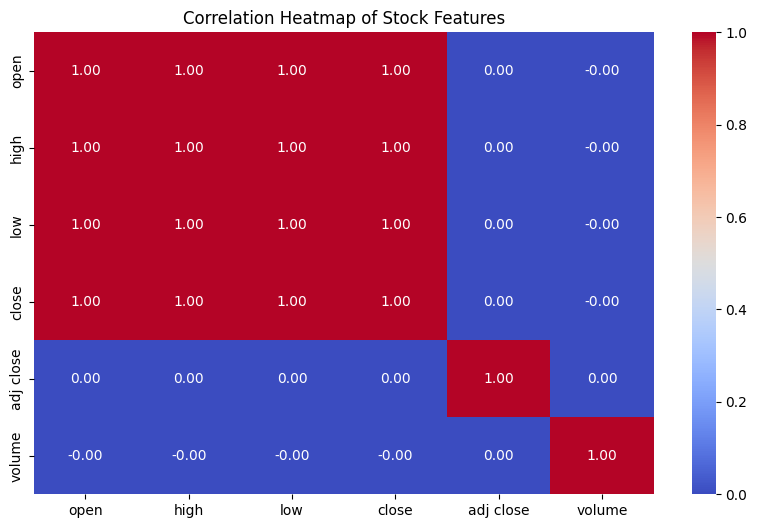

In [14]:
# Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

# Compute correlation matrix
corr_matrix = history_df_pd[['open', 'high', 'low', 'close', 'adj close', 'volume']].corr()

# Plot heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Stock Features")
plt.show()


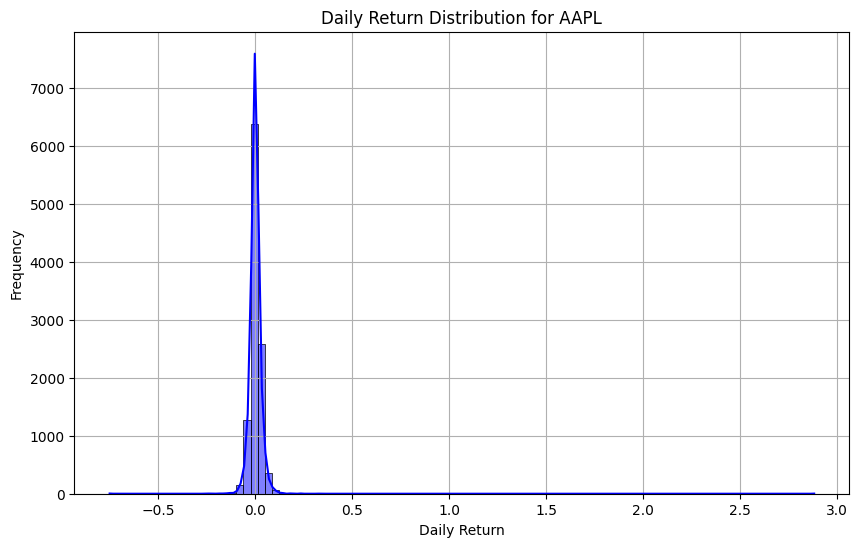

In [15]:
#Daily Returns Distribution

stock = 'AAPL'  # Replace with desired stock
df = history_df_pd[history_df_pd['StockName'] == stock].copy()
df = df.sort_values(by='date')
df['daily_return'] = df['close'].pct_change()

plt.figure(figsize=(10, 6))
sns.histplot(df['daily_return'].dropna(), bins=100, kde=True, color='blue')
plt.title(f"Daily Return Distribution for {stock}")
plt.xlabel("Daily Return")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [16]:
#Boxplots for Outlier Detection
plt.figure(figsize=(12, 6))
sns.boxplot(data=history_df_pd[['open', 'high', 'low', 'close', 'adj close', 'volume']])
plt.title("Boxplot of Stock Features")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


/var/folders/9r/gnfqm_ds1kv5c9vpr8k03jbh0000gn/T/ipykernel_17692/3586196273.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['daily_return'] = df.groupby('StockName')['close'].pct_change()


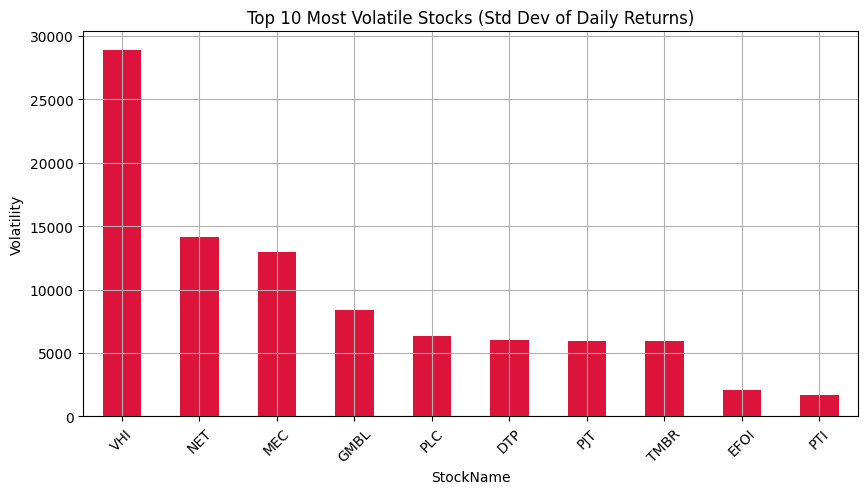

In [10]:
#Top 10 Most Volatile Stocks in the Model
df = history_df_pd.copy()
df['daily_return'] = df.groupby('StockName')['close'].pct_change()
volatility = df.groupby('StockName')['daily_return'].std().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 5))
volatility.plot(kind='bar', color='crimson')
plt.title("Top 10 Most Volatile Stocks (Std Dev of Daily Returns)")
plt.ylabel("Volatility")
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
